# Important Frequencies Selection

## Import Libraries and seed
Import the necessary libraries for data processing, model building, training, and evaluation. Adding a seed ensures reproducibility by making sure that the random number generation is consistent across different runs.

In [448]:
import os
import random

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import joblib
import matplotlib.pyplot as plt
import graphviz 
from torch.utils.data import DataLoader, TensorDataset
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import export_graphviz
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier

from scipy.stats import zscore



# import wandb

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    return seed

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Set seed for reproducibility
seed = set_seed(42)


Using device: cpu


In [2]:
def load_data_from_directory(input_path):
    data_frames = []
    for file in os.listdir(input_path):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(input_path, file), delimiter=';', header=0)
            data_frames.append(df)
    data = pd.concat(data_frames, ignore_index=True)

    return data

## Preprocessing Data
Define a function to preprocess the data. This includes encoding categorical labels and standardizing the features.

In [311]:
def calculate_averages_and_dispersion(df, data_percentage):

    results = []
    for (sample, freq), group in df.groupby(['Sample', 'Frequency (GHz)']):
        window_size = max(1, int(len(group) * data_percentage / 100))
        # print(f"Processing sample: {sample}, frequency: {freq} with window size: {window_size}")
        for start in range(0, len(group), window_size):
            window_data = group.iloc[start:start + window_size]
            mean_values = window_data[['LG (mV)', 'HG (mV)']].mean()
            std_deviation_values = window_data[['LG (mV)', 'HG (mV)']].std()
            results.append({
                'Frequency (GHz)': freq,
                'LG (mV) mean': mean_values['LG (mV)'],
                'HG (mV) mean': mean_values['HG (mV)'],
                'LG (mV) std deviation': std_deviation_values['LG (mV)'],
                'HG (mV) std deviation': std_deviation_values['HG (mV)'],
                # 'Thickness (mm)': window_data['Thickness (mm)'].iloc[0], ## COMMENT
                'Sample': sample,
            })
    results_df = pd.DataFrame(results)
    # results_df.to_csv(output_file, sep=';', index=False)
    # print(f"Processed {input_file} and saved to {output_file}")
    # print(results_df)
    return results_df

## Pivoting Frequency values to columns

In [312]:
def freq_as_variable(df, data_percentage):
    '''Modify df to have Frequency values (100,110,120 and so on) as input variables in the columns'''

    # Remove Thickness column
    if 'Thickness (mm)' in df.columns:
        df = df.drop(columns=['Thickness (mm)'])

    if data_percentage > 0:
        # 1s window_size 100/27s = 3.7% of the data is used for each window
        df_window = calculate_averages_and_dispersion(df, data_percentage) 

        # Add a unique identifier column to avoid duplicate entries in the index
        df_window['unique_id'] = df_window.groupby(['Sample', 'Frequency (GHz)']).cumcount()

        # Pivot the DataFrame to wide format
        df_pivot = df_window.pivot(index=['Sample', 'unique_id'], columns='Frequency (GHz)')

        # Flatten the MultiIndex columns - Ordered by Frequency + (HG mean, HG std deviation, LG mean, LG std deviation)
        df_pivot.columns = [' '.join([str(col[1]), str(col[0])]) for col in df_pivot.columns]

        # Drop columns with all NaN values
        df_pivot = df_pivot.dropna(axis=1, how='all')

        # Reset index to make 'Sample' and 'unique_id' columns again
        df_pivot = df_pivot.reset_index()

        # Remove 'unique_id' column
        df_pivot = df_pivot.drop(columns=['unique_id'])
    else:
        # If data_percentage is 0, do not calculate mean and std deviation, use the original data
        df['unique_id'] = df.groupby(['Sample', 'Frequency (GHz)']).cumcount()
        df_pivot = df.pivot(index=['Sample', 'unique_id'], columns='Frequency (GHz)')
        df_pivot.columns = [' '.join([str(col[1]), str(col[0])]) for col in df_pivot.columns]
        df_pivot = df_pivot.dropna(axis=1, how='all')
        df_pivot = df_pivot.reset_index()
        df_pivot = df_pivot.drop(columns=['unique_id'])

    # Optional - Sort the columns if needed
    df_pivot = df_pivot.reindex(sorted(df_pivot.columns), axis=1)

    return df_pivot

In [291]:
# Load the data from the directory
input_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/test/'
# input_path = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/test'

df = load_data_from_directory(input_path)

df = pd.concat([df[['Frequency (GHz)', 'LG (mV)', 'HG (mV)']], df[['Sample']]], axis=1)

df.head()

,Frequency (GHz),LG (mV),HG (mV),Sample
0,100.0,-7.080942,-0.854611,A1
1,100.0,67.024785,0.244141,A1
2,100.0,124.893178,-1.098776,A1
3,100.0,91.075571,0.000000,A1
4,100.0,48.956174,0.122094,A1


## Balance Dataset

C:\Users\Danim\AppData\Local\Temp\ipykernel_27260\1209927551.py:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


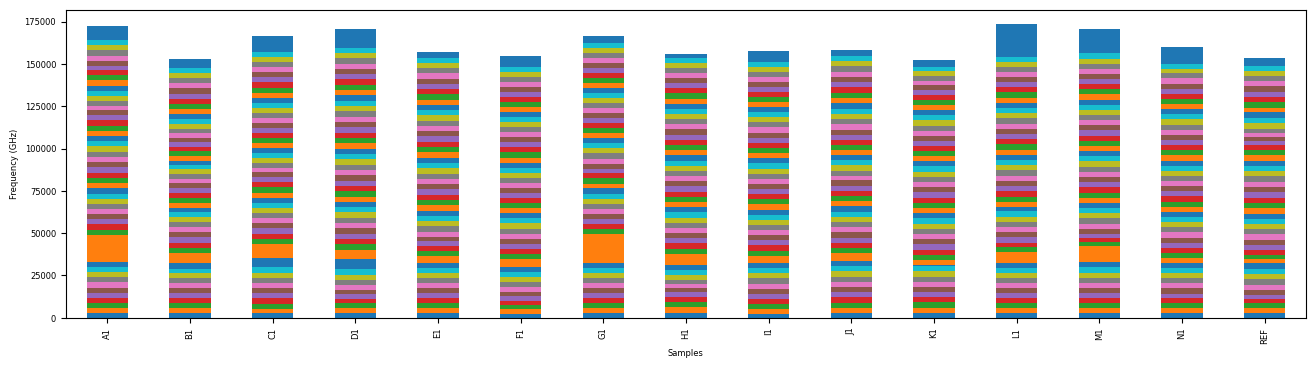

Mode value: 3033


C:\Users\Danim\AppData\Local\Temp\ipykernel_27260\1209927551.py:34: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


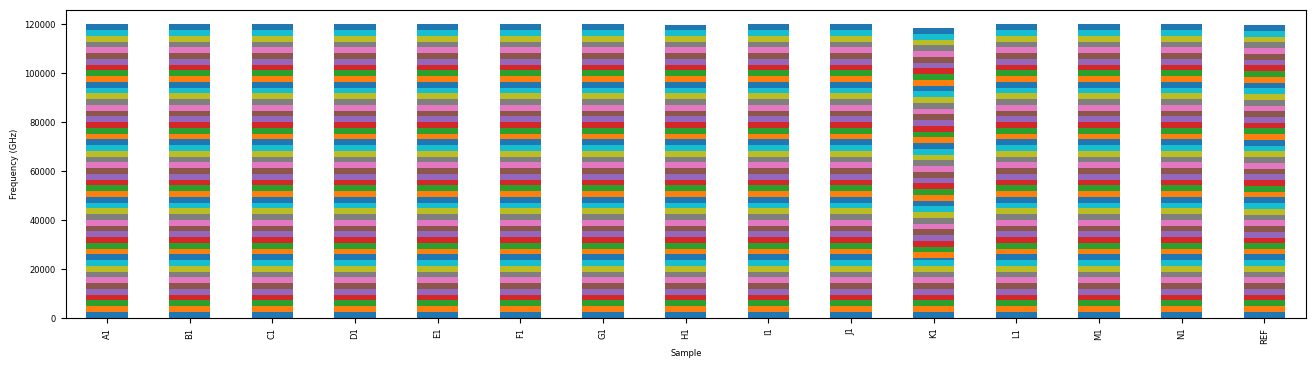

In [292]:
# Number of samples per frequency and Sample
bx = df.groupby(['Sample', 'Frequency (GHz)']).size().unstack().plot.bar(figsize=(16, 4), stacked=True)
bx.set_xlabel('Samples')
bx.set_ylabel('Frequency (GHz)')
plt.tight_layout()
#no legend
bx.get_legend().remove()
plt.show()

# Balance the data by taking the mode of samples per frequency
mode = df.groupby(['Sample', 'Frequency (GHz)']).size().mode()[0]
print(f'Mode value: {mode}')
mode = 2350

# Function to reduce samples to the mode value
def reduce_to_mode(df, sample, frequency, mode):
    # Filter the DataFrame for the specific sample and frequency
    freq_df = df[(df['Sample'] == sample) & (df['Frequency (GHz)'] == frequency)]
    # If the number of samples is greater than the mode, sample down to the mode
    if len(freq_df) > mode:
        return freq_df.sample(n=mode, random_state=42)
    return freq_df

# Apply the function to reduce samples for each combination of Sample and Frequency (GHz)
balanced_data = []
for (sample, frequency), group in df.groupby(['Sample', 'Frequency (GHz)']):
    balanced_data.append(reduce_to_mode(df, sample, frequency, mode))

# Combine the balanced samples into a single DataFrame
df_balanced = pd.concat(balanced_data)

bx = df_balanced.groupby(['Sample', 'Frequency (GHz)']).size().unstack().plot.bar(figsize=(16, 4), stacked=True)
bx.set_ylabel('Frequency (GHz)')
plt.tight_layout()
# legend small
bx.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
#remove legend
bx.get_legend().remove()
plt.show()

## Sample a test set

In [408]:
# train_set, test_set = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Sample']) 
test_percentage = 0.25
# train_set, test_set = train_test_split(df, test_size=test_percentage, random_state=42) 
# Shuffle the data
df_balanced = df_balanced.sample(frac=1, random_state=42)
# train_set, test_set = train_test_split(df_balanced, test_size=test_percentage, random_state=42) 

# stratify=df['Sample'] to keep the same proportion of samples in the train and test set


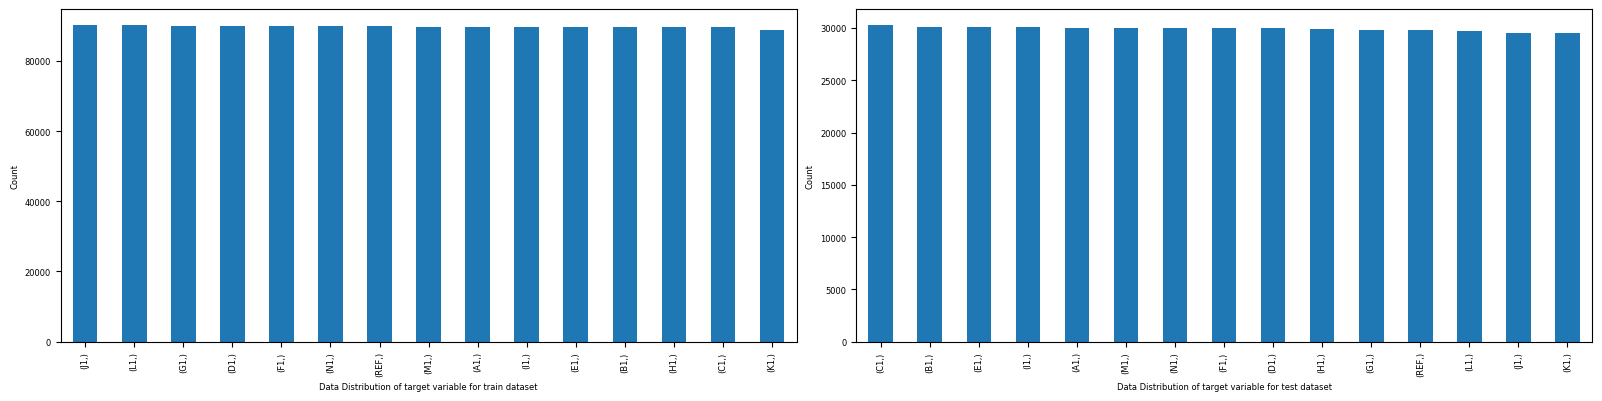

In [409]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

# Plot train set
train_set[['Sample']].value_counts().plot.bar(ax=ax[0], legend=False)
ax[0].set_xlabel('Data Distribution of target variable for train dataset')
ax[0].set_ylabel('Count')

# Plot test set
test_set[['Sample']].value_counts().plot.bar(ax=ax[1], legend=False)
ax[1].set_xlabel('Data Distribution of target variable for test dataset')
ax[1].set_ylabel('Count')

plt.tight_layout() 
plt.show()

In [410]:
train_ex = train_set.copy()

In [16]:
train_ex.info()
# train_ex.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 1436488 entries, 1723695 to 172769
Data columns (total 4 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   Frequency (GHz)  1436488 non-null  float64
 1   LG (mV)          1436488 non-null  float64
 2   HG (mV)          1436488 non-null  float64
 3   Sample           1436488 non-null  object 
dtypes: float64(3), object(1)
memory usage: 54.8+ MB


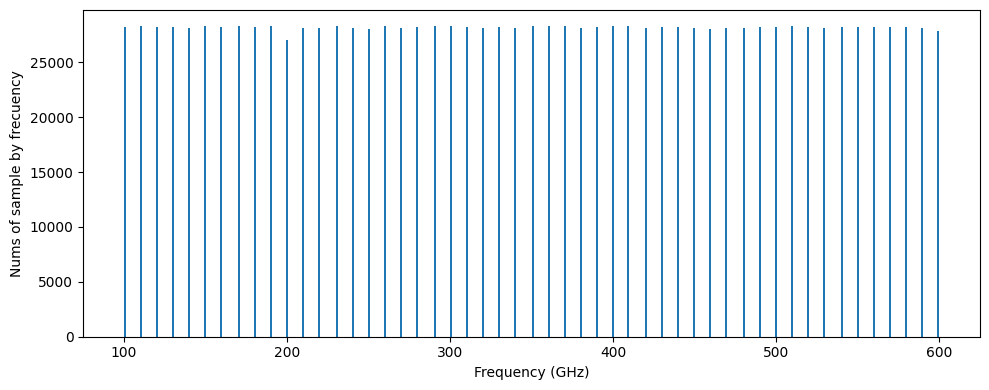

In [18]:

ax = train_ex['Frequency (GHz)'].plot.hist(figsize=(10, 4), bins=408)
# ax = test_set['Frequency (GHz)'].plot.hist(ax=ax, bins=408)
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('Nums of sample by frecuency')
plt.tight_layout()
plt.show()

In [411]:
# Calculate the percentage of data used for each window
time_window_s = 0.1
data_percentage = (100/(27*(1-test_percentage)))*time_window_s
data_percentage_test = (100/(27*(test_percentage)))*time_window_s

data_percentage = 0
data_percentage_test = 0

print(f"Data percentage: {data_percentage}%")
print(f"Data percentage test: {data_percentage_test}%")

# Load just a % of the data
# df_sample = train_set.sample(frac=0.02, random_state=42)

# Introduce Frequency values as input variables
train_set_test = freq_as_variable(train_set, data_percentage)
test_set_test = freq_as_variable(test_set, data_percentage_test)

# If a row has any NaN value, remove that row
train_set_test = train_set_test.dropna()
test_set_test = test_set_test.dropna()

#Save the processed data to a CSV file

output_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/train_set.csv'
output_path_test = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/test_set.csv'
# output_path = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/train_set.csv'
# output_path_test = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/test_set.csv'

# train_set_test.to_csv(output_path, sep = ';', index=False)
# test_set_test.to_csv(output_path_test, sep = ';', index=False)



Data percentage: 0%
Data percentage test: 0%


In [404]:
print(f"Train set shape: {train_set_test.shape}")
print(f"Test set shape: {test_set_test.shape}")
print(train_set_test.head())
print(test_set.shape)


Train set shape: (24365, 103)
Test set shape: (7726, 103)
   100.0 HG (mV)  100.0 LG (mV)  110.0 HG (mV)  110.0 LG (mV)  120.0 HG (mV)  \
0      -0.976610      57.990481      -0.488353      -2.930045      -0.488329   
1       0.488305      35.038456       0.366282      65.071420       0.244164   
2      -0.976682      62.995972      -0.488329      42.973995      -1.098752   
3      -0.366282      18.923210      -0.366306      13.551459      -0.244212   
4      -0.488305      48.834087       0.000024      14.894396      -1.220894   

   120.0 LG (mV)  130.0 HG (mV)  130.0 LG (mV)  140.0 HG (mV)  140.0 LG (mV)  \
0      89.732639      -1.587105      25.637895      -0.854588      90.587230   
1     126.358208      -0.366306      34.305945       0.122094      90.587229   
2      84.482975       0.122023      39.311439       0.244141      82.407519   
3     143.083884       0.244188      52.984983       0.488353      97.912341   
4     114.882198      -0.976658      36.381394      -0.854564

# Prepare Training Data
## Split the data into X and y


In [415]:
def preprocess_data(df, labels, freqs, eliminate_std_dev=False):
    # Reduce number of different samples for testing
    X_ = df[df['Sample'].isin(labels)]

    y_ = X_['Sample']

    X_ = X_.drop(columns=['Sample'])

    if freqs:
        # Subset of specific frequencies to use as input features (or without mean)
        columns = [f'{freq}.0 HG (mV) mean' for freq in freqs] + \
                  [f'{freq}.0 LG (mV) mean' for freq in freqs] + \
                  [f'{freq}.0 HG (mV)' for freq in freqs] + \
                  [f'{freq}.0 LG (mV)' for freq in freqs] + \
                  [f'{freq}.0 HG (mV) std deviation' for freq in freqs] + \
                  [f'{freq}.0 LG (mV) std deviation' for freq in freqs] 


        # Filter columns that exist in X_
        existing_columns = [col for col in columns if col in X_.columns]

        # Check if existing_columns is empty
        if not existing_columns:
            print("No matching columns found in X_.")
        else:
            X_ = X_[existing_columns]

        # Sort columns by frequency value
        X_ = X_.reindex(sorted(X_.columns), axis=1)

    if eliminate_std_dev:
        # Eliminate std dev columns from the input features
        X_ = X_.drop(columns=[col for col in X_.columns if 'std deviation' in col])

    return X_, y_


In [ ]:
# Subset of specific Samples to use in the training
labels = ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1', 'K1', 'L1', 'M1', 'N1', 'REF']
# labels = ['E1', 'H1', 'REF']

# Subset of specific frequencies to use as input features, If freqs = [] then all frequencies are used
freqs = [200,210,230,250,270,280,290,300,310,320,330,360]
freqs = [200,210,230,250,270,280,290,300,310,320,330,360,340,350,370,380,390,400,410,430,440]

freqs = []

# # Shuffle the data
# train_set_test_shuffle = train_set_test.sample(frac=1, random_state=42)
# test_set_test_shuffle = test_set_test.sample(frac=1, random_state=42)


X_train, y_train = preprocess_data(train_set_test, labels, freqs, eliminate_std_dev=True) 
X_test, y_test = preprocess_data(test_set_test, labels, freqs, eliminate_std_dev=True)

# Encode the target variable if it's categorical
if y_train.dtype == 'object':
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)

if y_test.dtype == 'object':
    y_test = le.transform(y_test)


# le is the fitted LabelEncoder - Saving Encoder
joblib.dump(le, 'label_encoder.pkl')

X_train
# y_train





,100.0 HG (mV),100.0 LG (mV),110.0 HG (mV),110.0 LG (mV),120.0 HG (mV),120.0 LG (mV),130.0 HG (mV),130.0 LG (mV),140.0 HG (mV),140.0 LG (mV),...,560.0 HG (mV),560.0 LG (mV),570.0 HG (mV),570.0 LG (mV),580.0 HG (mV),580.0 LG (mV),590.0 HG (mV),590.0 LG (mV),600.0 HG (mV),600.0 LG (mV)
2082,1.342940,140.275922,0.122070,-22.463679,1.098752,120.620200,0.488329,46.026126,-1.587129,102.795750,...,5.005494,-1.098767,13.795629,0.244170,19.655719,0.244170,9.522647,0.000000,19.411549,-1.465023
11472,0.366235,115.736790,-2.075410,54.205835,1.587081,146.990605,1.098776,51.642045,0.122094,63.850567,...,44.927359,0.244170,32.352582,-0.854596,28.445855,1.098767,34.916371,-0.244170,32.718837,1.342937
20886,4.272938,2.807960,0.366282,10.499328,-0.000024,35.770968,-0.244117,34.183860,0.976682,69.710657,...,15.260652,0.366256,-0.366256,-1.220852,5.615920,1.342937,14.894396,-1.220852,11.720181,1.098767
22920,0.122094,71.541937,0.732541,46.270296,0.244188,172.018076,0.976682,34.183860,0.244188,70.198998,...,43.828592,-0.854596,17.946526,-0.976682,34.428030,-0.122085,55.304602,0.244170,24.905384,0.244170
25165,25.515810,0.732511,-0.122023,92.174345,-0.366306,245.025034,0.122094,44.683188,-0.732541,68.123549,...,40.776461,-0.244170,26.126236,0.976682,42.729825,-0.366256,57.135880,0.000000,36.015138,-0.854596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24081,36.503479,-0.610426,-0.122070,29.788792,0.732517,174.703954,0.000024,44.683188,-0.122094,78.989133,...,47.979489,1.098767,31.497985,-0.366256,12.452692,0.732511,65.315589,0.488341,40.532291,0.000000
5652,0.732493,128.799906,0.854564,73.006959,-0.732493,106.580402,-0.732493,33.207178,1.098752,43.218166,...,-10.010988,0.244170,15.626907,1.220852,9.644732,-0.244170,-5.860090,1.342937,12.330607,0.122085
860,-0.366235,75.570749,0.488353,19.411549,-0.122070,115.858878,1.953363,22.463679,0.244164,98.889023,...,8.301795,-0.122085,17.946526,0.000000,25.149554,-0.732511,26.126236,0.000000,8.545965,0.000000
16856,-0.244141,48.467830,-0.000024,31.497985,0.000000,98.278603,0.854635,54.694176,0.000048,72.640702,...,47.857404,-0.488341,37.602246,-1.465023,41.020632,0.366256,47.857404,0.610426,19.899890,-0.122085


### Principal Component Analysis

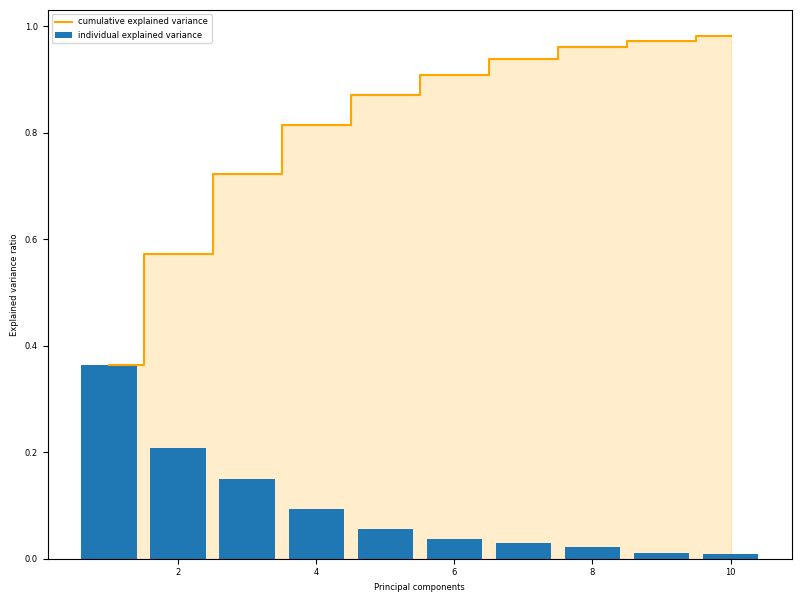

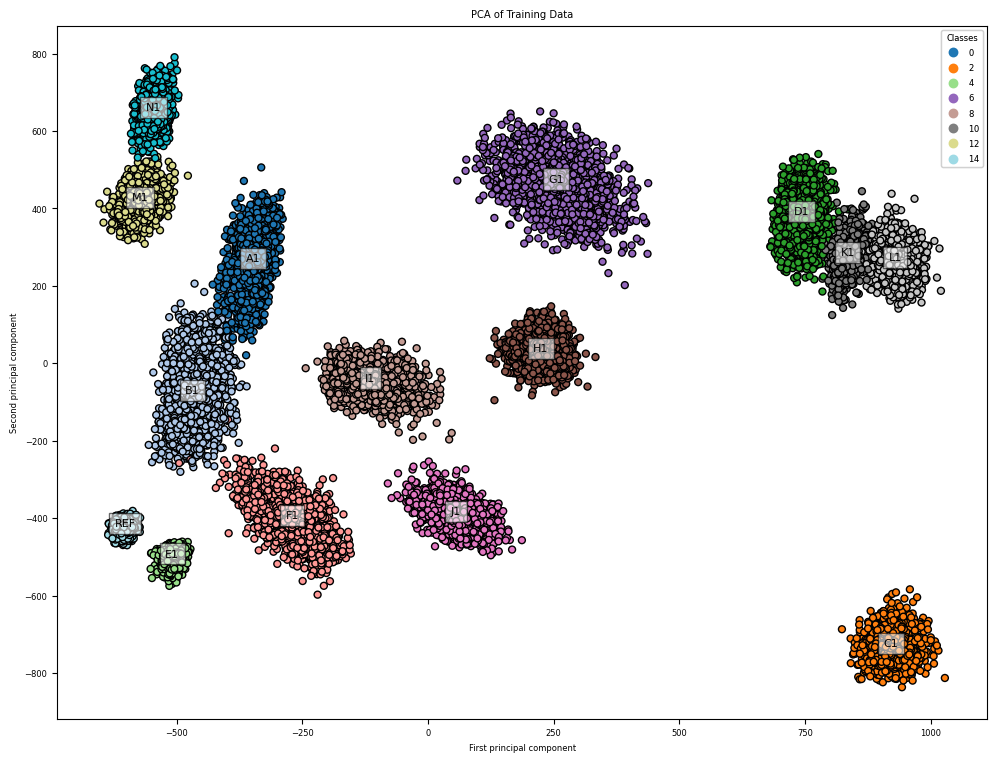

Component 1:
320.0 HG (mV)    0.468938
310.0 HG (mV)    0.457746
330.0 HG (mV)    0.352399
250.0 HG (mV)    0.340057
200.0 HG (mV)    0.108626
230.0 HG (mV)    0.086511
300.0 HG (mV)    0.052309
270.0 HG (mV)    0.051033
280.0 HG (mV)    0.020628
100.0 LG (mV)    0.003971
Name: 0, dtype: float64 

340.0 HG (mV)   -0.242074
390.0 HG (mV)   -0.238891
350.0 HG (mV)   -0.212619
400.0 HG (mV)   -0.160574
370.0 HG (mV)   -0.157264
410.0 HG (mV)   -0.156857
380.0 HG (mV)   -0.155509
430.0 HG (mV)   -0.094100
440.0 HG (mV)   -0.092572
450.0 HG (mV)   -0.092139
Name: 0, dtype: float64 

Component 2:
230.0 HG (mV)    0.775793
410.0 HG (mV)    0.081607
310.0 HG (mV)    0.070562
200.0 HG (mV)    0.058124
460.0 HG (mV)    0.042073
300.0 HG (mV)    0.030544
270.0 HG (mV)    0.029714
120.0 LG (mV)    0.018044
370.0 HG (mV)    0.016917
590.0 HG (mV)    0.015226
Name: 1, dtype: float64 

290.0 HG (mV)   -0.433415
250.0 HG (mV)   -0.316319
330.0 HG (mV)   -0.166654
350.0 HG (mV)   -0.160905
360.0 HG (mV

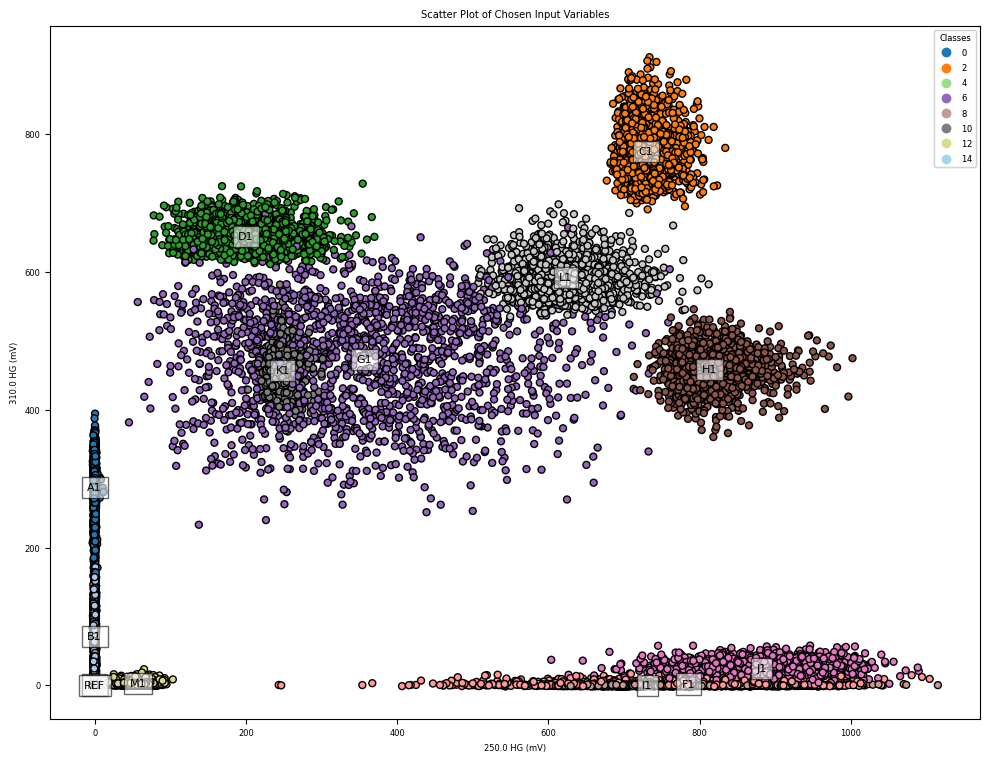

In [422]:
# Apply PCA
n_components =10
pca = PCA(n_components)  # Reduce to 2 components for visualization
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
y_pca = y_train

# Plot the explained variance ratio
plt.figure(figsize=(8, 6))
plt.step(range(1, n_components+1), np.cumsum(pca.explained_variance_ratio_), where='mid', label='cumulative explained variance', color='orange')
plt.fill_between(range(1, n_components+1), np.cumsum(pca.explained_variance_ratio_), step='mid', alpha=0.2, color='orange')
plt.bar(range(1, n_components+1), pca.explained_variance_ratio_, alpha=1.0, align='center', label='individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


### VISUALIZATION ###
# Plot the PCA components (first two components for visualization)
plt.figure(figsize=(12, 9))
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_pca, cmap = 'tab20',
                      edgecolor='k', s=25)
# Produce a legend with the unique colors from the scatter
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)

# Show a class label on the data points (just one label per class in total)
offset = 10
for i, label in enumerate(labels):
    plt.text(X_train_pca[y_pca == i, 0].mean() , X_train_pca[y_pca == i, 1].mean() + offset, label,
             ha='center', va='center', size=8, bbox=dict(facecolor='w', alpha=0.6))


plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('PCA of Training Data')


plt.show()


# Show how the principal components are related to the original features
# Create a DataFrame with the PCA components
components = pd.DataFrame(pca.components_, columns=X_train.columns)
# Transpose the DataFrame
components = components.T
# Display the highest and lowest n variables of the first 3 components
n= 10
for i in range(n_components):
    print(f"Component {i+1}:")
    print(components[i].nlargest(n), '\n')
    print(components[i].nsmallest(n), '\n')


## NON PCA VISUALIZATION ##
# Choose specific variables for visualization
var1 = '250.0 HG (mV)'
var2 = '310.0 HG (mV)'
# var2 = '320.0 HG (mV) std deviation'


# Plot the chosen input variables for visualization
plt.figure(figsize=(12, 9))
scatter = plt.scatter(X_train[var1], X_train[var2], c=y_train, cmap='tab20',
                      edgecolor='k', s=25)
# Produce a legend with the unique colors from the scatter
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)

# Show a class label on the data points (just one label per class in total)
offset = 0
unique_labels = np.unique(y_train)
for i, label in enumerate(unique_labels):
    plt.text(X_train[y_train == label][var1].mean(), X_train[y_train == label][var2].mean() + offset, 
             labels[label], ha='center', va='center', size=8, bbox=dict(facecolor='w', alpha=0.6))

plt.xlabel(var1)
plt.ylabel(var2)
plt.title('Scatter Plot of Chosen Input Variables')

plt.show()





In [423]:
# Model Parameters
input_size = X_train.shape[1]
output_size = len(np.unique(y_train))
seed = set_seed(42)

input_size, output_size

# print(f'input_size: {input_size}, output_size: {output_size}')
# print(X_train, y_train)

(102, 15)

### Random Forest Model

In [424]:
def random_forest_model(X_train, y_train, seed):
    # Define Random Forest model with parameters to reduce overfitting
    rf_model = RandomForestClassifier(
        n_estimators=10,  # Increase the number of trees
        criterion='log_loss',
        max_depth=3,  # Limit the maximum depth of the trees
        min_samples_split=5,  # Minimum number of samples required to split an internal node
        min_samples_leaf=2,  # Minimum number of samples required to be at a leaf node
        bootstrap=True,  # Use bootstrap sampling
        random_state=seed
    )
    # Train the model
    rf_model.fit(X_train, y_train)
    return rf_model

In [366]:
def gradient_boosting_model(X_train, y_train, seed):
    # Define Gradient Boosting model
    gb_model = GradientBoostingClassifier(n_estimators=10, random_state=seed)
    # Train the model
    gb_model.fit(X_train, y_train)
    return gb_model

### Define Naive-Bayes model


In [367]:
def naive_bayes_model(X_train, y_train):
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)
    return nb_model

### Logistic Regression

In [368]:
def logistic_regression_model(X_train, y_train, seed):
    lr_model = LogisticRegression(max_iter=10000, random_state=seed)
    lr_model.fit(X_train, y_train)
    return lr_model

Model 1 - Accuracy: 0.9910691172663733
Model 1 - Precision: 0.9918589963677363
Model 1 - Recall: 0.9910691172663733
Model 1 - F1: 0.9904218013820506
Model 1 - Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       552
           1       1.00      1.00      1.00       563
           2       0.99      1.00      0.99       544
           3       1.00      1.00      1.00       540
           4       1.00      1.00      1.00       540
           5       1.00      1.00      1.00       551
           6       1.00      1.00      1.00       512
           7       1.00      1.00      1.00       471
           8       1.00      1.00      1.00       521
           9       1.00      1.00      1.00       543
          10       1.00      0.67      0.81       209
          11       0.90      1.00      0.95       539
          12       1.00      1.00      1.00       548
          13       1.00      1.00      1.00       554
      

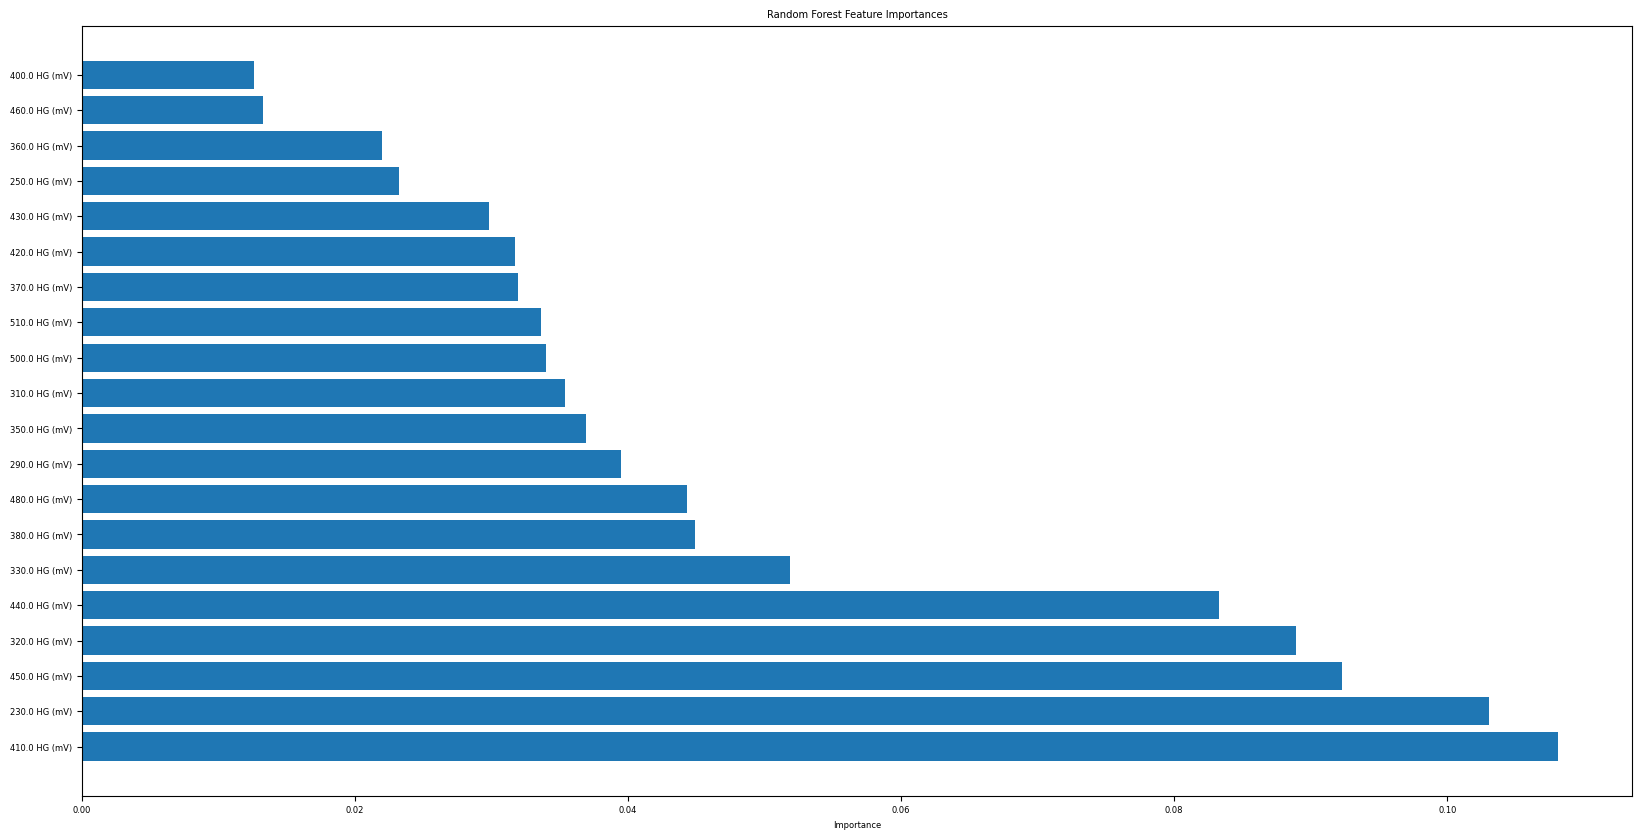

In [438]:
### Train models ###
rf_model = random_forest_model(X_train, y_train, seed)
nb_model = naive_bayes_model(X_train, y_train)
lr_model = logistic_regression_model(X_train, y_train, seed)

# Predictions
y_pred = []
y_pred.append(rf_model.predict(X_test))
y_pred.append(nb_model.predict(X_test))
y_pred.append(lr_model.predict(X_test))

# Save the model
# joblib.dump(rf_model, 'random_forest_model.pkl')
# joblib.dump(nb_model, 'naive_bayes_model.pkl')
# joblib.dump(lr_model, 'logistic_regression_model.pkl')

# # Create a DataFrame to compare
# df_comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
# print(df_comparison.head(10))

# Calculate metrics
for i, y_pred_i in enumerate(y_pred):
    accuracy = accuracy_score(y_test, y_pred_i)
    precision = precision_score(y_test, y_pred_i, average='weighted')
    recall = recall_score(y_test, y_pred_i, average='weighted')
    f1 = f1_score(y_test, y_pred_i, average='weighted')

    print(f"Model {i+1} - Accuracy: {accuracy}")
    print(f"Model {i+1} - Precision: {precision}")
    print(f"Model {i+1} - Recall: {recall}")
    print(f"Model {i+1} - F1: {f1}")

    # Classification report
    print(f"Model {i+1} - Classification Report:\n", classification_report(y_test, y_pred_i), '\n')

    # Predictions made per class with its label encoded value
    print(f"Model {i+1} - Predictions Counter:\n", Counter(y_pred_i), '\n')

# Feature importance (Find 10 most important variables with its name and importance value)
rf_feature_importances = rf_model.feature_importances_
# lr_feature_importances = lr_model.coef_[0]

feature_names = X_train.columns
rf_feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': rf_feature_importances})
# lr_feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': lr_feature_importances})

rf_feature_importances_df = rf_feature_importances_df.sort_values('Importance', ascending=False)
# lr_feature_importances_df = lr_feature_importances_df.sort_values('Importance', ascending=False)

# Font size
plt.rcParams.update({'font.size': 6})

n = 20
print("Random Forest Feature Importances:\n", rf_feature_importances_df.head(n))


plt.figure(figsize=(20, 10))
plt.barh(rf_feature_importances_df['Feature'][:n], rf_feature_importances_df['Importance'][:n])
plt.xlabel('Importance')
plt.title('Random Forest Feature Importances')
plt.show()


# print("Logistic Regression Feature Importances:\n", lr_feature_importances_df.head(204))
# plt.figure(figsize=(20, 10))
# plt.barh(lr_feature_importances_df['Feature'][:n], lr_feature_importances_df['Importance'][:n])
# plt.xlabel('Importance')
# plt.title('Logistic Regression Feature Importances')
# plt.show()

# # sum all the importances of LR
# print(lr_feature_importances_df['Importance'].sum())


### Permutation Feature Importance

C:\Users\Danim\AppData\Local\Temp\ipykernel_27260\3995820570.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx])


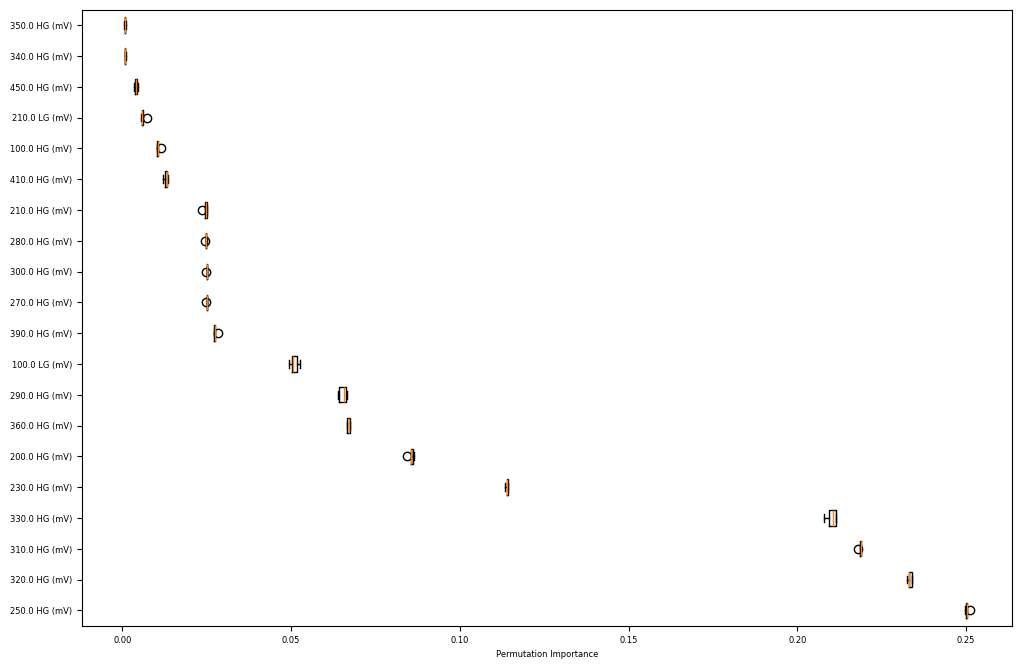

Permutation Importance:

250.0 HG (mV): 0.2502
320.0 HG (mV): 0.2333
310.0 HG (mV): 0.2187
330.0 HG (mV): 0.2101
230.0 HG (mV): 0.1140
200.0 HG (mV): 0.0856
360.0 HG (mV): 0.0671
290.0 HG (mV): 0.0654
100.0 LG (mV): 0.0510
390.0 HG (mV): 0.0275
270.0 HG (mV): 0.0250
300.0 HG (mV): 0.0250
280.0 HG (mV): 0.0248
210.0 HG (mV): 0.0246
410.0 HG (mV): 0.0129
100.0 HG (mV): 0.0106
210.0 LG (mV): 0.0060
450.0 HG (mV): 0.0040
340.0 HG (mV): 0.0008
350.0 HG (mV): 0.0008


In [429]:
result = permutation_importance(nb_model, X_train, y_train, n_repeats=5, random_state=seed, n_jobs=8)

# Preserve n most important features
n = 20
sorted_idx = result.importances_mean.argsort()[::-1][:n]  # Sort indices in descending order

plt.figure(figsize=(12, 8))
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx])
plt.xlabel('Permutation Importance')
plt.show()

# Print n most important features from highest to lowest with their values
print("Permutation Importance:\n")
for i in sorted_idx:
    print(f"{X_train.columns[i]}: {result.importances_mean[i]:.4f}")


In [376]:
# Export Random Forest model with graphviz
feature_names = X_train.columns.tolist()  # Replace with your actual feature names

# Export the first tree in the Random Forest
dot_data = export_graphviz(
    rf_model.estimators_[0], 
    out_file=None, 
    filled=True, 
    rounded=True, 
    special_characters=True,
    feature_names=feature_names
)

# Create a graph from the dot data
graph = graphviz.Source(dot_data)

# Render the graph to a file
graph.render('random_forest_model')


'random_forest_model.pdf'

## Confusion Matrix

In [377]:
# # Confusion matrix with matplotlib

def plot_confusion_matrix(y_true, y_pred, labels):
    conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    
    for i in range(len(labels)):
        for j in range(len(labels)):
            plt.text(j, i, f'{conf_matrix[i, j]}\n({conf_matrix[i, j] / np.sum(conf_matrix, axis=1)[i] * 100:.1f}%)',
                     horizontalalignment="center",
                     verticalalignment="center",
                     fontsize=9,
                     ha='center', va='center', color='white')
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(np.arange(len(labels)), labels, rotation=45)
    plt.yticks(np.arange(len(labels)), labels)
    plt.title('Confusion Matrix')
    plt.show()


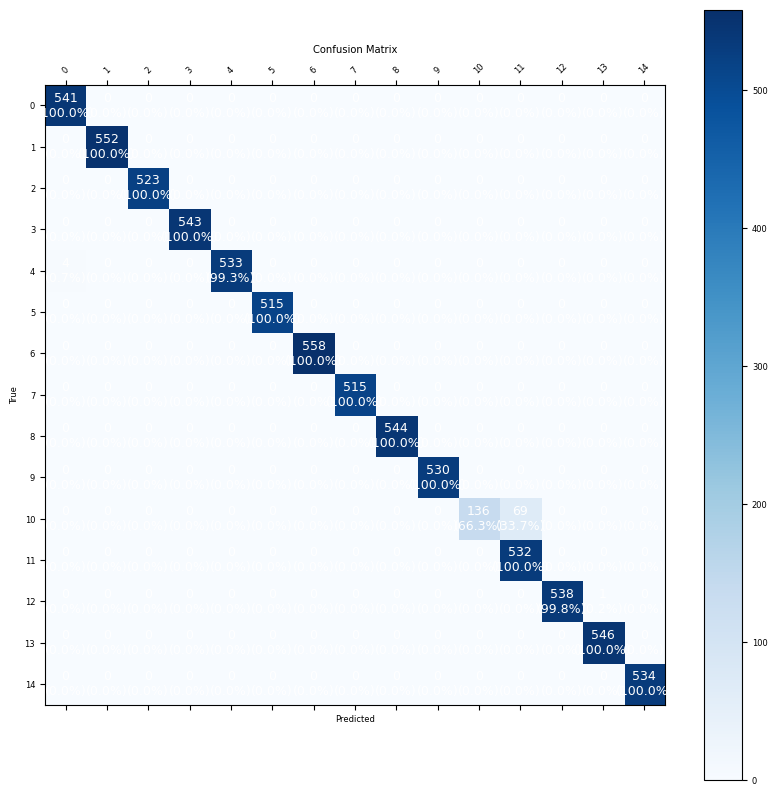

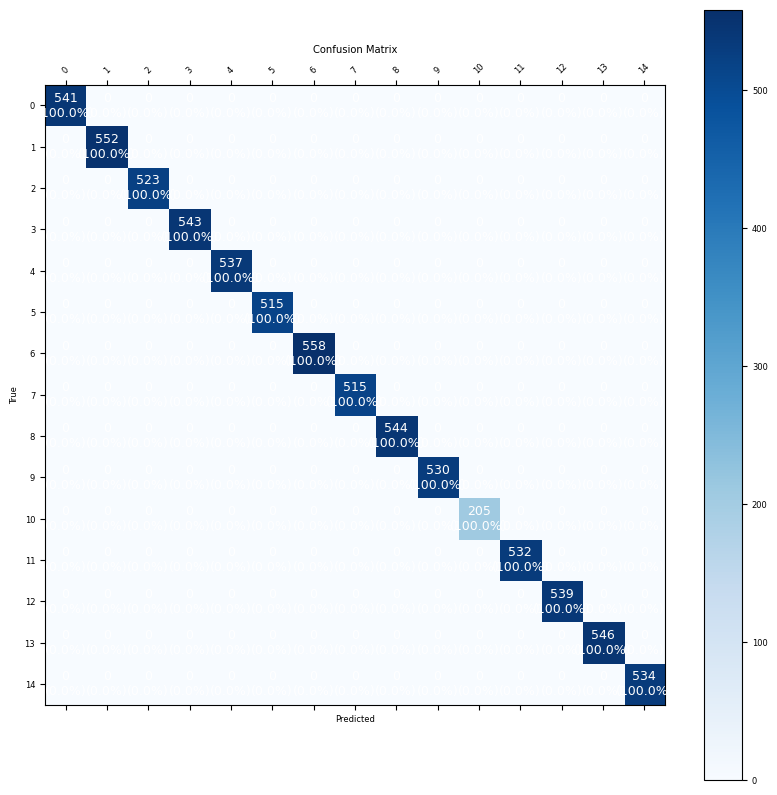

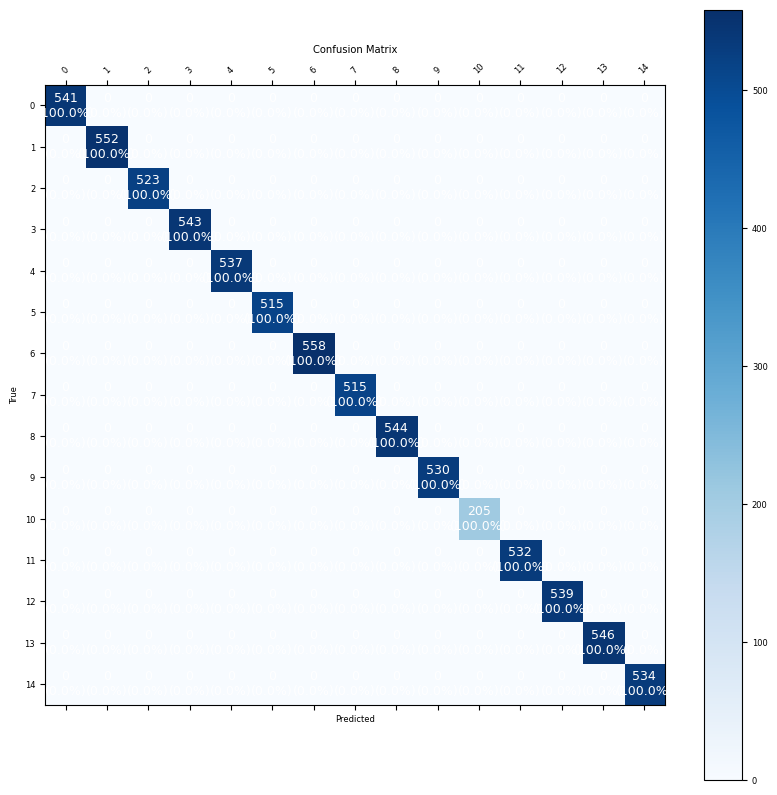

In [378]:
plot_confusion_matrix(y_test, y_pred[0], np.unique(y_test))
plot_confusion_matrix(y_test, y_pred[1], np.unique(y_test))
plot_confusion_matrix(y_test, y_pred[2], np.unique(y_test))

## Load and preprocess Other Test Data (Experiment 2)
Prepare new sample for testing (Testing other samples, out of initial dataset)

In [ ]:
# input_path = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_2_plastics/processed/test/'
input_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_2_plastics/processed/test/'

df_new_sample = load_data_from_directory(input_path)
df_new_sample = pd.concat([df_new_sample[['Frequency (GHz)', 'LG (mV)', 'HG (mV)']], df_new_sample[['Sample']]], axis=1)

# labels = ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1', 'K1', 'L1', 'M1', 'N1', 'REF']
labels = [ 'E1', 'H1', 'REF']
labels = df_new_sample['Sample'].unique()

# freqs = []
# freqs = [200,210,230,250,270,280,290,300,310,320,330,360]
freqs = [200,210,230,250,270,280,290,300,310,320,330,360, 340,350,370,380,390,400,410,430,440]
freqs = []

df_new_sample = df_new_sample[df_new_sample['Sample'].isin(labels)]

# freqs = [320,380]

# Add .0 on every Frequency column value to match the format of the training data
# df_new_sample['Frequency (GHz)'] = df_new_sample['Frequency (GHz)'].astype(str) + '.0'


# Time window
time_window_s = 1
sample_time_s = 14 * 6
data_percentage = (100/sample_time_s)*time_window_s
print(f"Data percentage: {data_percentage}%")

data_percentage = 0

# Introduce Frequency values as input variables
df_new_sample = freq_as_variable(df_new_sample, data_percentage) # 0.22

df_new_sample = df_new_sample.dropna()

X_new_sample, y_new_sample = preprocess_data(df_new_sample, labels, freqs, eliminate_std_dev=False)

# load the label encoder
le = joblib.load('label_encoder.pkl')
# y_new_sample = le.transform(y_new_sample)


# ### Remove outliers from the new sample data
# # Select only numeric columns
# df_numeric = X_new_sample.select_dtypes(include=[np.number])

# # Calculate the z-scores of each value in the numeric DataFrame
# z_scores = np.abs(zscore(df_numeric))

# # Find all rows where the z-scores are greater than 3 standard deviations
# outliers = np.where(z_scores > 3)

# # Get the indices of the rows
# outlier_indices = outliers[0]

# # Get the unique indices
# unique_outliers = np.unique(outlier_indices)

# # Ensure the indices to drop exist in the DataFrame
# indices_to_drop = df_new_sample.index.intersection(unique_outliers)

# # Print the unique indices
# print(indices_to_drop)

# # Remove the outliers
# X_new_sample = X_new_sample.drop(index=indices_to_drop)
# y_new_sample = y_new_sample.drop(index=indices_to_drop)
# X_new_sample = X_new_sample.dropna()
# y_new_sample = y_new_sample.dropna()

# Continue with the rest of your code
num_samples = len(y_new_sample)
print(X_new_sample.head())


Data percentage: 1.1904761904761905%
Index([    0,    12,    16,    23,    27,    36,    37,    42,    44,    52,
       ...
       13695, 13702, 13703, 13706, 13711, 13713, 13714, 13715, 13718, 13722],
      dtype='int64', length=2401)
   100.0 HG (mV)  100.0 LG (mV)  110.0 HG (mV)  110.0 LG (mV)  120.0 HG (mV)  \
1      -0.366259      70.931511      -0.488353      28.445855       1.831222   
2      -0.488353       1.342937      -0.366187      32.840922      -0.244188   
3      -0.122094      31.253815      -0.488281      31.986326      -0.244141   
4       0.488353      48.467830       0.244188      24.417043      -0.854588   
5       0.488400      34.672201      -0.244164      66.536443      -0.122118   

   120.0 LG (mV)  130.0 HG (mV)  130.0 LG (mV)  140.0 HG (mV)  140.0 LG (mV)  \
1     116.957639       1.098752      37.235990      -0.244212      74.471980   
2      98.278603       1.709175      22.341594      -0.366235      65.315589   
3      99.133198       0.488329      31.49

Component 1:
230.0 HG (mV)    0.499624
330.0 HG (mV)    0.462758
350.0 HG (mV)    0.315385
320.0 HG (mV)    0.301821
250.0 HG (mV)    0.232454
390.0 HG (mV)    0.118281
450.0 HG (mV)    0.076282
410.0 HG (mV)    0.063799
370.0 HG (mV)    0.047171
480.0 HG (mV)    0.038811
Name: 0, dtype: float64 

290.0 HG (mV)   -0.463756
360.0 HG (mV)   -0.181695
400.0 HG (mV)   -0.063882
430.0 HG (mV)   -0.053075
420.0 HG (mV)   -0.045163
310.0 HG (mV)   -0.038036
470.0 HG (mV)   -0.030414
100.0 LG (mV)   -0.021684
120.0 LG (mV)   -0.016834
510.0 HG (mV)   -0.014872
Name: 0, dtype: float64 

Component 2:
330.0 HG (mV)    0.499830
310.0 HG (mV)    0.432085
290.0 HG (mV)    0.406524
250.0 HG (mV)    0.215984
320.0 HG (mV)    0.197893
350.0 HG (mV)    0.105372
100.0 LG (mV)    0.042365
120.0 LG (mV)    0.035207
520.0 HG (mV)    0.006033
580.0 HG (mV)    0.004871
Name: 1, dtype: float64 

390.0 HG (mV)   -0.287577
230.0 HG (mV)   -0.230111
370.0 HG (mV)   -0.223170
410.0 HG (mV)   -0.176344
340.0 HG (mV

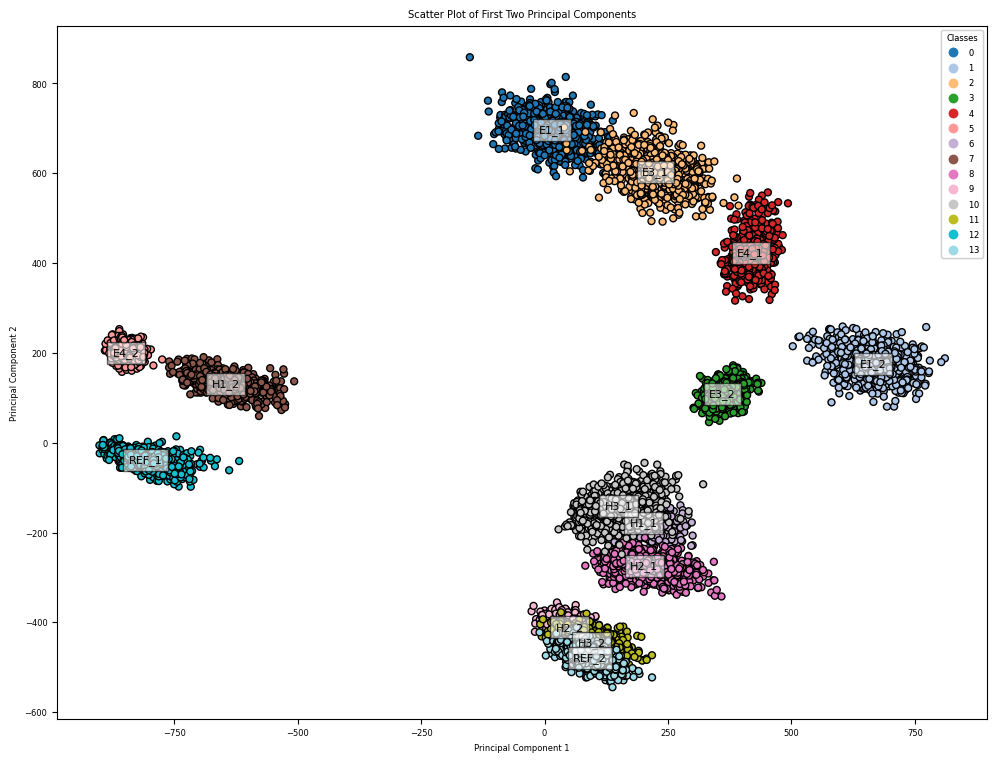

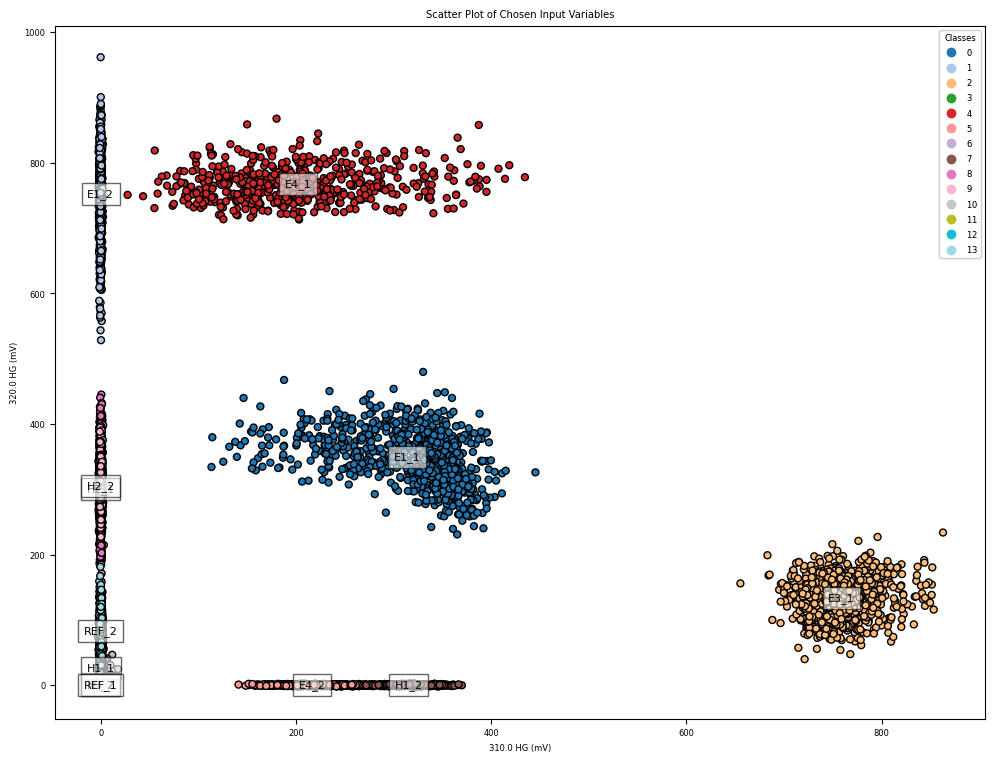

In [476]:
# Encode the labels
le = LabelEncoder()
y_new_sample_encoded = le.fit_transform(y_new_sample)

# Perform PCA
pca = PCA(n_components=2)
X_new_sample_pca = pca.fit_transform(X_new_sample)

# Create a DataFrame with the PCA components
components = pd.DataFrame(pca.components_, columns=X_new_sample.columns)
components = components.T

# Display the highest and lowest n variables of the first 3 components
n = 10
for i in range(pca.n_components_):
    print(f"Component {i+1}:")
    print(components[i].nlargest(n), '\n')
    print(components[i].nsmallest(n), '\n')

# Plot the PCA components (first two components for visualization)
plt.figure(figsize=(12, 9))
scatter = plt.scatter(X_new_sample_pca[:, 0], X_new_sample_pca[:, 1], c=y_new_sample_encoded, cmap='tab20',
                      edgecolor='k', s=25)
# Produce a legend with the unique colors from the scatter
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)

# Show a class label on the data points (just one label per class in total)
offset = 0.1
unique_labels = np.unique(y_new_sample_encoded)
for i, label in enumerate(unique_labels):
    plt.text(X_new_sample_pca[y_new_sample_encoded == label][:, 0].mean(), 
             X_new_sample_pca[y_new_sample_encoded == label][:, 1].mean() + offset, 
             le.inverse_transform([label])[0], ha='center', va='center', size=8, bbox=dict(facecolor='w', alpha=0.6))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot of First Two Principal Components')

plt.show()


# Plot 2 input variables
var1 = '310.0 HG (mV)'
var2 = '320.0 HG (mV)'

plt.figure(figsize=(12, 9))
scatter = plt.scatter(X_new_sample[var1], X_new_sample[var2], c=y_new_sample_encoded, cmap='tab20',
                      edgecolor='k', s=25)
# Produce a legend with the unique colors from the scatter
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)

# Show a class label on the data points (just one label per class in total)
offset = 0.1
unique_labels = np.unique(y_new_sample_encoded)

for i, label in enumerate(unique_labels):
    plt.text(X_new_sample[y_new_sample_encoded == label][var1].mean(), 
             X_new_sample[y_new_sample_encoded == label][var2].mean() + offset, 
             le.inverse_transform([label])[0], ha='center', va='center', size=8, bbox=dict(facecolor='w', alpha=0.6))
    
plt.xlabel(var1)
plt.ylabel(var2)
plt.title('Scatter Plot of Chosen Input Variables')

plt.show()




C:\Users\Danim\AppData\Local\Temp\ipykernel_27260\899557725.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx])


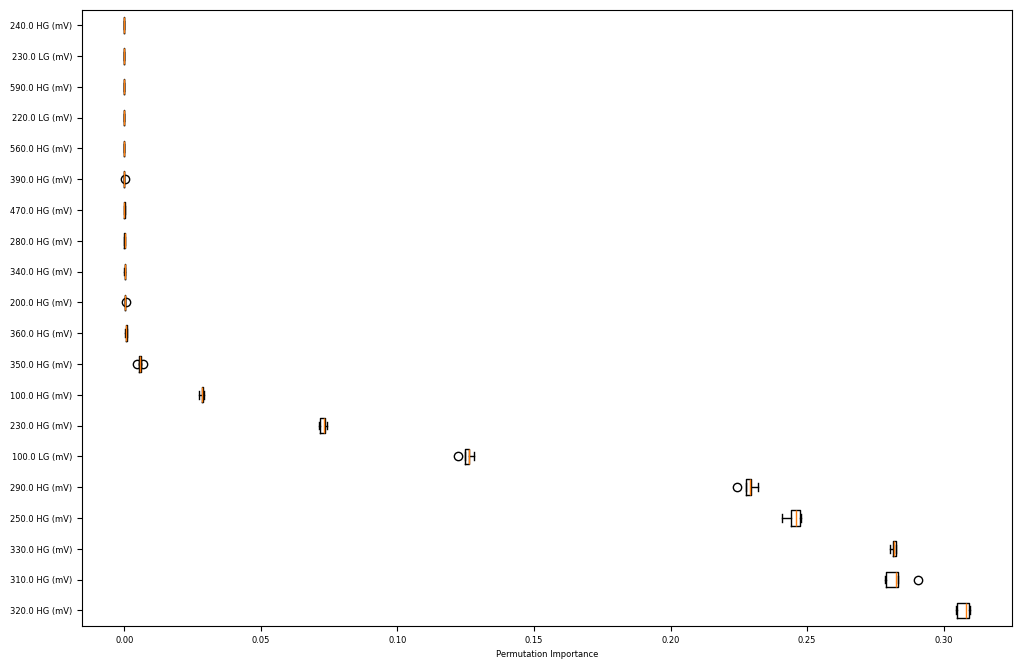

Permutation Importance:

320.0 HG (mV): 0.3073
310.0 HG (mV): 0.2827
330.0 HG (mV): 0.2818
250.0 HG (mV): 0.2453
290.0 HG (mV): 0.2285
100.0 LG (mV): 0.1254
230.0 HG (mV): 0.0727
100.0 HG (mV): 0.0284
350.0 HG (mV): 0.0058
360.0 HG (mV): 0.0006
200.0 HG (mV): 0.0004
340.0 HG (mV): 0.0001
280.0 HG (mV): 0.0000
470.0 HG (mV): 0.0000
390.0 HG (mV): 0.0000
560.0 HG (mV): 0.0000
220.0 LG (mV): 0.0000
590.0 HG (mV): 0.0000
230.0 LG (mV): 0.0000
240.0 HG (mV): 0.0000


In [ ]:
result = permutation_importance(nb_model, X_new_sample, y_new_sample_encoded, n_repeats=5, random_state=seed, n_jobs=8)

# Preserve n most important features
n = 20
sorted_idx = result.importances_mean.argsort()[::-1][:n]  # Sort indices in descending order

plt.figure(figsize=(12, 8))
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx])
plt.xlabel('Permutation Importance')
plt.show()

# Print n most important features from highest to lowest with their values
print("Permutation Importance:\n")
for i in sorted_idx:
    print(f"{X_new_sample.columns[i]}: {result.importances_mean[i]:.4f}")

In [ ]:
y_pred = rf_model.predict(X_new_sample, y_new_sample_encoded)
# y_pred = nb_model.predict(X_new_sample, y_new_sample_encoded)
# y_pred = lr_model.predict(X_new_sample, y_new_sample_encoded)

# Calculate metrics
accuracy = accuracy_score(y_new_sample, y_pred)
precision = precision_score(y_new_sample, y_pred, average='weighted')
recall = recall_score(y_new_sample, y_pred, average='weighted')
f1 = f1_score(y_new_sample, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

# Convert the label encoded values back to the original class names
# y_new_sample = le.inverse_transform(y_new_sample)
# y_pred = le.inverse_transform(y_pred)

# Classification report
print(classification_report(le.inverse_transform(y_new_sample), le.inverse_transform(y_pred)), )

# Predictions made per class with its label encoded value
print(Counter(y_pred))

y_new_sample_encoded = le.inverse_transform(y_new_sample)
y_pred_encoded = le.inverse_transform(y_pred)

plot_confusion_matrix(y_new_sample_encoded, y_pred_encoded, le.classes_)

ValueError: Mix of label input types (string and number)

In [183]:
# Load trained model
rf_model = joblib.load('random_forest_model.pkl')

# Predictions
y_pred = rf_model.predict(X_new_sample)



ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- 100.0 HG (mV) mean
- 100.0 HG (mV) std deviation
- 100.0 LG (mV) mean
- 100.0 LG (mV) std deviation
- 110.0 HG (mV) mean
- ...


## Feature Importance TBD

## Labels

| Original Label | Encoded Value |
|----------------|---------------|
| A1             | 0             |
| B1             | 1             |
| C1             | 2             |
| D1             | 3             |
| E1             | 4             |
| F1             | 5             |
| G1             | 6             |
| H1             | 7             |
| I1             | 8             |
| J1             | 9             |
| K1             | 10            |
| L1             | 11            |
| M1             | 12            |
| N1             | 13            |
| REF            | 14            |